In [1]:
from commonfunctions import *
import numpy as np
from numpy.linalg import norm
from skimage.filters import *
import matplotlib.pyplot as plt
import cv2 as cv 
import os
import time

In [2]:
def binarize(img, method):
    if len(img.shape) > 2 :
        img = rgb2gray(img)
    if method == 'skimage_local':
        return img >= threshold_local(img, 31, offset=3)
    if method == 'skimage_sauvola':
        return img >= threshold_sauvola(img, 31)
    if method == 'cv_adaptive':
        return cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,41,10)

def get_staff_corners(img, contour): #this function doens't work well, it needs a different implementation
    image_corners = np.array([[0, 0], [img.shape[1], 0], [0, img.shape[0]], [img.shape[1], img.shape[0]]])
    staff_corners = np.zeros((4,2))

    staff_corners[0] = max(contour, key=lambda point:norm(point[0] - image_corners[3]))
    staff_corners[1] = max(contour, key=lambda point:norm(point[0] - image_corners[2]))
    staff_corners[2] = max(contour, key=lambda point:norm(point[0] - image_corners[1]))
    staff_corners[3] = max(contour, key=lambda point:norm(point[0] - image_corners[0]))
    return staff_corners

def project(img, corners): 
    wdith = min(norm(corners[0] - corners[1]), norm(corners[2] - corners[3]))
    height = max(norm(corners[0] - corners[2]), norm(corners[1] - corners[3]))
    
    src = np.array([[0, 0], [wdith, 0], [0, height], [wdith, height]], np.float32)
    corners = corners.astype("float32")

    h = cv.getPerspectiveTransform(corners, src)
    return cv.warpPerspective(img, h, (int(wdith), int(height)))


def fix_projection(image_binary, image_grayscale):
    #adding extra padding
    image_binary = np.pad(image_binary, 20, 'constant', constant_values=0)
    image_grayscale = np.pad(image_grayscale, 20, 'constant', constant_values=0)

    img = cv.dilate(image_binary, cv.getStructuringElement(cv.MORPH_ELLIPSE,(20,20)))

    contours, _ = cv.findContours(img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE); 
    largest_contour = max(contours, key = cv.contourArea)#key = lambda cnt : cv.arcLength(cnt, False))

    hull = cv.convexHull(largest_contour); 

    staff_corners = get_staff_corners(img, hull)

    # ----plotting----
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(largest_contour[:, :, 0], largest_contour[:, :, 1], linewidth=2, c='g')
    #for cnt in contours:
    #    ax.plot(cnt[:, :, 0], cnt[:, :, 1], linewidth=1, c='g')
    ax.plot(hull[:, :, 0], hull[:, :, 1], linewidth=1, c="b")
    ax.scatter(staff_corners[:, 0], staff_corners[:, 1], linewidth=1, c="r")
    # ----------------

    img = project(image_grayscale, staff_corners);  
    img = unsharp_mask(img) #sharpening the image after projection improves later binarization
    return img

def display(img):
    cv.namedWindow('image',cv.WINDOW_NORMAL)
    cv.resizeWindow('image', 1920, 1080)
    cv.imshow('image', img)
    cv.waitKey()

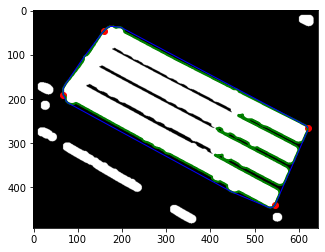

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


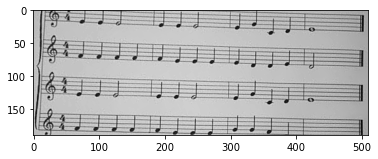

In [3]:
img = cv.imread("input/" + "tilted.jpg", 0)

img_b = binarize(img, "cv_adaptive"); 

img = fix_projection(img_b, img)

plt.show()
plt.imshow(img, cmap=plt.cm.gray)
io.imsave("output.png", img)